In [501]:
import pandas as pd
import numpy as np
import math

In [502]:
# This tool needs a pip install daft-property-price-register
# in case you dont want to install on your machine , I have added the resulting download to git
from daft_property_price_register.models.daft_sale import DaftSales

In [503]:
sales = DaftSales.load()

In [504]:
ps = sales.serialize()

In [506]:
ps_df = pd.DataFrame(ps)
ps_df.shape
ps_df.to_csv('daft_ppr.csv')

In [507]:
# Drop rows that dont contain info on rooms
ps_df_room = ps_df[ps_df['bedrooms'].notnull() & ps_df['bathrooms'].notnull()]

In [508]:
ps_df_room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74203 entries, 0 to 443435
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   address                74203 non-null  object 
 1   price                  74203 non-null  int64  
 2   date                   74203 non-null  object 
 3   property_type          74203 non-null  object 
 4   bedrooms               74203 non-null  float64
 5   bathrooms              74203 non-null  float64
 6   not_full_market_price  74203 non-null  bool   
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 4.0+ MB


In [509]:
ps_df_room.head()

,address,price,date,property_type,bedrooms,bathrooms,not_full_market_price
0,"11 Latchford Green, Castaheany, Clonee, Clonee...",310000,21/05/21,Terraced House,2.0,3.0,False
1,"112 Killester Park, Killester, Killester, Co. ...",505000,21/05/21,Semi-Detached House,3.0,2.0,False
2,"1 Bellview, Faunmore, Bantry, Bantry, Co. Cork",345000,21/05/21,Detached House,3.0,3.0,False
4,"139 Killester Park, Killester, Killester, Co. ...",550000,21/05/21,Terraced House,3.0,2.0,False
5,"14 Marian Rd, Rathfarnham, Rathfarnham, Co. Du...",265000,21/05/21,Semi-Detached House,3.0,3.0,False


In [510]:
# check for missing values with a sum of null in each colums.
ps_df_room.isnull().sum()
# no more null values so all good.

address                  0
price                    0
date                     0
property_type            0
bedrooms                 0
bathrooms                0
not_full_market_price    0
dtype: int64

In [511]:
ps_df_room.shape

(74203, 7)

In [512]:
import re
from datetime import datetime

# convert date colum to date object
pd.options.mode.chained_assignment = None
ps_df_room['date'] = pd.to_datetime(ps_df_room['date'])
# split out county and region into their own colum with regex
ps_df_room['county'] = ps_df_room['address'].str.extract(r'(Co\W\s\w+)')
ps_df_room['region'] = ps_df_room['address'].str.extract(r'([A-Z,a-z]+,\sCo\.)')
# cleaned up the region column after the regex instruction
ps_df_room['region'] = ps_df_room['region'].str.strip(", Co.")

In [513]:

# Many propertys are not the full market price , so need to drop these from the dataset
ps_df_room = ps_df_room.loc[~ps_df_room.not_full_market_price, :]
ps_df_room.shape

(72576, 9)

In [514]:
# Need to quantify and drop nans
ps_df_room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72576 entries, 0 to 443435
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   address                72576 non-null  object        
 1   price                  72576 non-null  int64         
 2   date                   72576 non-null  datetime64[ns]
 3   property_type          72576 non-null  object        
 4   bedrooms               72576 non-null  float64       
 5   bathrooms              72576 non-null  float64       
 6   not_full_market_price  72576 non-null  bool          
 7   county                 72576 non-null  object        
 8   region                 71902 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 5.1+ MB


In [515]:
ps_df_room.head()

,address,price,date,property_type,bedrooms,bathrooms,not_full_market_price,county,region
0,"11 Latchford Green, Castaheany, Clonee, Clonee...",310000,2021-05-21,Terraced House,2.0,3.0,False,Co. Dublin,lonee
1,"112 Killester Park, Killester, Killester, Co. ...",505000,2021-05-21,Semi-Detached House,3.0,2.0,False,Co. Dublin,Killester
2,"1 Bellview, Faunmore, Bantry, Bantry, Co. Cork",345000,2021-05-21,Detached House,3.0,3.0,False,Co. Cork,Bantry
4,"139 Killester Park, Killester, Killester, Co. ...",550000,2021-05-21,Terraced House,3.0,2.0,False,Co. Dublin,Killester
5,"14 Marian Rd, Rathfarnham, Rathfarnham, Co. Du...",265000,2021-05-21,Semi-Detached House,3.0,3.0,False,Co. Dublin,Rathfarnham


In [516]:
# investigate the high null values in region
null_region = ps_df_room[ps_df_room['region'].isnull()]
null_region.head()

,address,price,date,property_type,bedrooms,bathrooms,not_full_market_price,county,region
509,"166 South Circular Rd, Dublin 8, Co. Dublin",570000,2021-09-04,Terraced House,3.0,2.0,False,Co. Dublin,NaN
564,"5 Macken St, Dublin 2, Co. Dublin",635000,2021-09-04,Terraced House,3.0,2.0,False,Co. Dublin,NaN
1536,"102 Ashington Rise, Kinvara, Navan Rd, Dublin ...",385000,2021-03-30,Terraced House,3.0,3.0,False,Co. Dublin,NaN
1875,"33 Caragh Rd, Old Cabra Rd, Dublin 7, Co. Dublin",425000,2021-03-26,Terraced House,3.0,2.0,False,Co. Dublin,NaN
3075,"18 Belleville, Blackhorse Ave, Dublin 7, Co. D...",495000,2021-11-03,End of Terrace House,2.0,2.0,False,Co. Dublin,NaN


In [517]:
# need to experiment with the regex to extract double barreled regions , for now drop the NaN
ps_df_room = ps_df_room.dropna()

In [518]:
ps_df_room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71902 entries, 0 to 443435
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   address                71902 non-null  object        
 1   price                  71902 non-null  int64         
 2   date                   71902 non-null  datetime64[ns]
 3   property_type          71902 non-null  object        
 4   bedrooms               71902 non-null  float64       
 5   bathrooms              71902 non-null  float64       
 6   not_full_market_price  71902 non-null  bool          
 7   county                 71902 non-null  object        
 8   region                 71902 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 5.0+ MB


In [519]:
# explore the county colum
countys = ps_df_room['county']
countys.value_counts().sort_index()
# there are non counties in the dataframe ie Co. Golf,Co. Glen & Co Rd

Co, Galway          10
Co. Carlow         438
Co. Cavan          938
Co. Clare         1885
Co. Cork          8996
Co. Donegal       1692
Co. Dublin       23954
Co. Galway        3301
Co. Glen             2
Co. Golf             1
Co. Kerry         2052
Co. Kildare       3462
Co. Kilkenny       963
Co. Laois         1260
Co. Leitrim        383
Co. Limerick      1945
Co. Longford       436
Co. Louth         1567
Co. Mayo          1270
Co. Meath         4478
Co. Monaghan       301
Co. Offaly         918
Co. Rd               1
Co. Roscommon      631
Co. Sligo          808
Co. Tipperary     1437
Co. Waterford     1882
Co. Westmeath     1949
Co. Wexford       2288
Co. Wicklow       2654
Name: county, dtype: int64

In [520]:
# see if we can put this in a regular expression. tried with function but problerms
# remove the non counties
ps_df_room = ps_df_room[ps_df_room.county != 'Co. Glen']
ps_df_room = ps_df_room[ps_df_room.county != 'Co. Golf']
ps_df_room = ps_df_room[ps_df_room.county != 'Co. Rd']
# there is a typo 'Co,' v 'Co.' with galway , need to correct.
ps_df_room['county'] = ps_df_room['county'].str.replace('Co, Galway','Co. Galway')

In [521]:
countys = ps_df_room['county']
countys.value_counts().sort_index()
# Counies are now clean

Co. Carlow         438
Co. Cavan          938
Co. Clare         1885
Co. Cork          8996
Co. Donegal       1692
Co. Dublin       23954
Co. Galway        3311
Co. Kerry         2052
Co. Kildare       3462
Co. Kilkenny       963
Co. Laois         1260
Co. Leitrim        383
Co. Limerick      1945
Co. Longford       436
Co. Louth         1567
Co. Mayo          1270
Co. Meath         4478
Co. Monaghan       301
Co. Offaly         918
Co. Roscommon      631
Co. Sligo          808
Co. Tipperary     1437
Co. Waterford     1882
Co. Westmeath     1949
Co. Wexford       2288
Co. Wicklow       2654
Name: county, dtype: int64

In [522]:
# Inspect the propeerty_type colum
countys = ps_df_room['property_type']
countys.value_counts().sort_index()
# all good , shows we have 10 property types

Apartment For Sale       5804
Bungalow For Sale        2690
Detached House          21047
Duplex For Sale          1429
End of Terrace House     3794
House For Sale           1495
Semi-Detached House     27883
Site For Sale              23
Terraced House           7652
Townhouse                  81
Name: property_type, dtype: int64

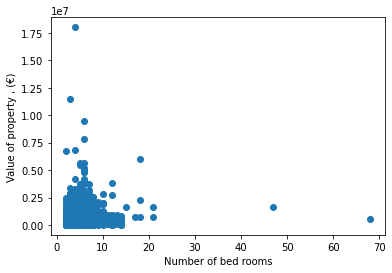

<Figure size 432x288 with 0 Axes>

In [523]:
import matplotlib.pyplot as plt
plt.scatter(ps_df_room['bedrooms'],ps_df_room['price'])
plt.ylabel('Value of property , (€)')
plt.xlabel('Number of bed rooms')
plt.show()
plt.savefig("price_bedroom_1.png", dpi=300)
# the plot shows some outliers that need to be investigate

In [524]:
big_rooms = ps_df_room[ps_df_room.bedrooms > 11]
print(big_rooms)

                                                  address    price       date  \
154               213 Richmond Road, Fairview, Co. Dublin   900000 2021-04-23   
175     Apartments 1 Naveny Place, Ballybofey, Co. Don...  1645750 2021-04-16   
13095          Knockdrin Castle, Mullingar, Co. Westmeath  3850000 2020-12-22   
48312         Moat Lodge, Adamstown Rd, Lucan, Co. Dublin   552000 2020-03-27   
50250   Drishane House, Killarney Rd, Millstreet, Co. ...   370000 2020-03-16   
56073        Ballea Castle, Ballea, Carrigaline, Co. Cork   800000 2020-01-31   
60299                  The Courtyard, Bunratty, Co. Clare   300000 2019-12-20   
70628           Bru Na Mara, Mace Pier, Carna, Co. Galway   237000 2019-05-11   
99361                     Ard Wilton, 1, Wilton, Co. Cork   800000 2019-10-05   
114797            9 Grosvenor Road, Rathmines, Co. Dublin  1624000 2019-01-24   
125837                         136, Rathmines, Co. Dublin  2704135 2018-10-26   
130561             49 Grosve

In [525]:

# having reviewed the data on daft.ie ,properties over 7 bedrooms tended 
# to be a block of apartments or comercisal properties, so will leave out.
# it amounts to 120 properties ,this wont reduce my amount of properties by very much
# while also eliminating outliers and erronous data like 68 and 47 bedroom properties


In [526]:
ps_df_room = ps_df_room[ps_df_room.bedrooms <= 6]
ps_df_room.shape

(71370, 9)

In [527]:
# the data goes back over 10 years, will only use more recent data from 2019 on for the model.
from datetime import datetime
dates = datetime(2019,5,30)
ps_df_room = ps_df_room[ps_df_room.date >= dates]
ps_df_room.shape
# this has reduced me down to 18K properties

(17741, 9)

In [528]:
# Stats from dataset
print(f"The minimum price for a house was.. €{np.min(ps_df_room['price'])}")
print(f"The max price for a house was.. €{np.max(ps_df_room['price'])}")
print(f"The mean price for a house was.. €{np.mean(ps_df_room['price'])}")
print(f"The max price for a house was.. €{np.max(ps_df_room['price'])}")
print(f"The STD price for a house was.. €{np.std(ps_df_room['price'])}")

The minimum price for a house was.. €6000
The max price for a house was.. €6765735
The mean price for a house was.. €340340.84392086125
The max price for a house was.. €6765735
The STD price for a house was.. €258034.918698619


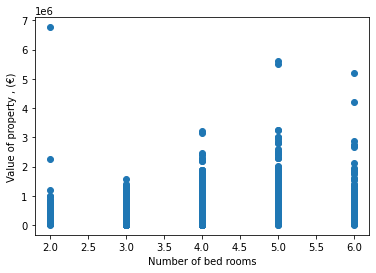

<Figure size 432x288 with 0 Axes>

In [529]:
import matplotlib.pyplot as plt
plt.scatter(ps_df_room['bedrooms'],ps_df_room['price'])
plt.ylabel('Value of property , (€)')
plt.xlabel('Number of bed rooms')
plt.show()
plt.savefig("price_bedroom_2.png", dpi=300)
# the plot shows some outliers that need to be investigate but the data looks roughly linear in nature.

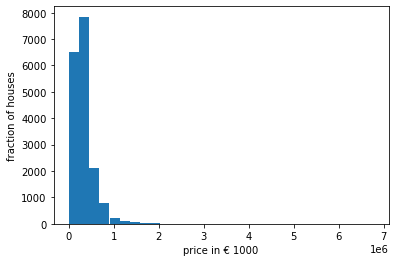

In [530]:
plt.hist(ps_df_room['price'], bins = 30)
plt.xlabel('price in € 1000')
plt.ylabel('fraction of houses')
plt.savefig("price_houses.png", dpi=300)

In [531]:

from sklearn.preprocessing import scale
scaled_price = scale(ps_df_room['price'])

Text(0, 0.5, 'fraction of houses')

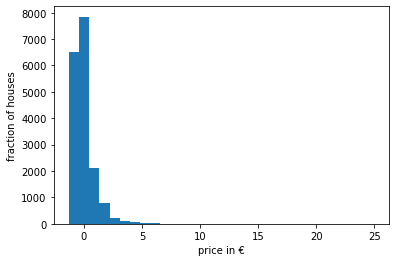

In [532]:
# after scaling the price it does not look to be evenly distributed
plt.hist(price_scaled, bins = 30)
plt.xlabel('price in €')
plt.ylabel('fraction of houses')

In [533]:
# check out the bathrooms col
bath_room = ps_df_room['bathrooms']
bath_room.value_counts().sort_index()

2.0     9066
3.0     7207
4.0     1171
5.0      217
6.0       56
7.0       17
8.0        5
10.0       1
15.0       1
Name: bathrooms, dtype: int64

In [534]:
# studying the relationship between bedrooms and bathrooms , It looks likle  house with more then
# 3 bathrooms more than the number of bedrooms was a bad entry. ie 4 bed room houses with 15 bathrooms.
#  To fix this will drop any houses that the difference between number of bedrooms and bathrooms is greater than 3
ps_df_room = ps_df_room[(ps_df_room.bathrooms)-(ps_df_room.bedrooms) <= 3]

In [535]:
# check out the bathrooms col
bath_room = ps_df_room['bathrooms']
bath_room.value_counts().sort_index()

2.0    9066
3.0    7207
4.0    1171
5.0     217
6.0      56
7.0      17
8.0       5
Name: bathrooms, dtype: int64

In [536]:
ps_df_room.shape

(17739, 9)

In [537]:
ps_df_room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17739 entries, 0 to 116758
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   address                17739 non-null  object        
 1   price                  17739 non-null  int64         
 2   date                   17739 non-null  datetime64[ns]
 3   property_type          17739 non-null  object        
 4   bedrooms               17739 non-null  float64       
 5   bathrooms              17739 non-null  float64       
 6   not_full_market_price  17739 non-null  bool          
 7   county                 17739 non-null  object        
 8   region                 17739 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.2+ MB


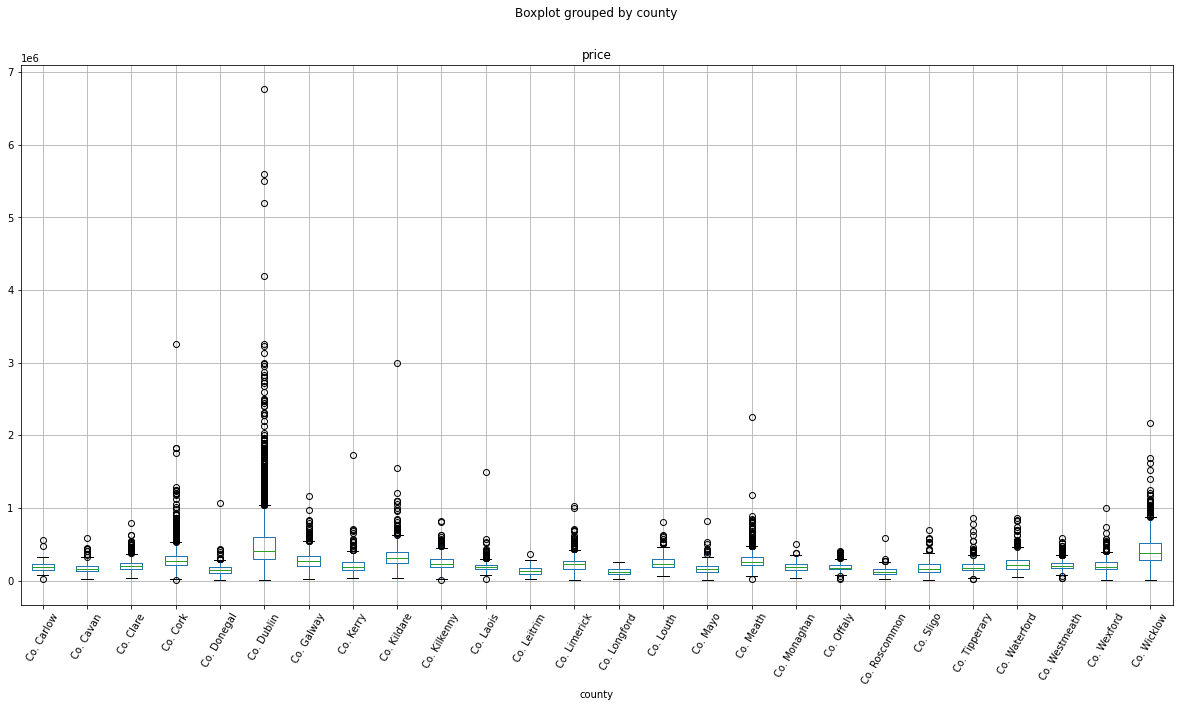

In [538]:
# make box plot of price v county
ps_df_room.boxplot('price','county',rot=60, figsize = (20,10))
plt.savefig("price_county_box.png", dpi=300)
# interseting observation here ,Co Limeric is surprising low prices, given that it has ther 3rd largest city
# in the country. Co Wiclow is higher than expected but its proximity to Dublin has driven up house prices there.

In [539]:
# Need to drop address as already extracted  info.
ps_df_room.drop('address',axis=1,inplace = True)
# need to drop date colum as logreg doesnt like timestamps
ps_df_room.drop('date',axis=1,inplace = True)
# need to drop regions as regex gives too many iterations error
ps_df_room.drop('region',axis=1,inplace = True)


In [540]:
# Make dummy variables from categorical colums
ps_df_dv = pd.get_dummies(ps_df_room)

In [541]:
ps_df_dv.head()


,price,bedrooms,bathrooms,not_full_market_price,property_type_Apartment For Sale,property_type_Bungalow For Sale,property_type_Detached House,property_type_Duplex For Sale,property_type_End of Terrace House,property_type_House For Sale,...,county_Co. Meath,county_Co. Monaghan,county_Co. Offaly,county_Co. Roscommon,county_Co. Sligo,county_Co. Tipperary,county_Co. Waterford,county_Co. Westmeath,county_Co. Wexford,county_Co. Wicklow
0,310000,2.0,3.0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,505000,3.0,2.0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,345000,3.0,3.0,False,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,550000,3.0,2.0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,265000,3.0,3.0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [542]:
ps_df_dv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17739 entries, 0 to 116758
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   price                               17739 non-null  int64  
 1   bedrooms                            17739 non-null  float64
 2   bathrooms                           17739 non-null  float64
 3   not_full_market_price               17739 non-null  bool   
 4   property_type_Apartment For Sale    17739 non-null  uint8  
 5   property_type_Bungalow For Sale     17739 non-null  uint8  
 6   property_type_Detached House        17739 non-null  uint8  
 7   property_type_Duplex For Sale       17739 non-null  uint8  
 8   property_type_End of Terrace House  17739 non-null  uint8  
 9   property_type_House For Sale        17739 non-null  uint8  
 10  property_type_Semi-Detached House   17739 non-null  uint8  
 11  property_type_Site For Sale         1773

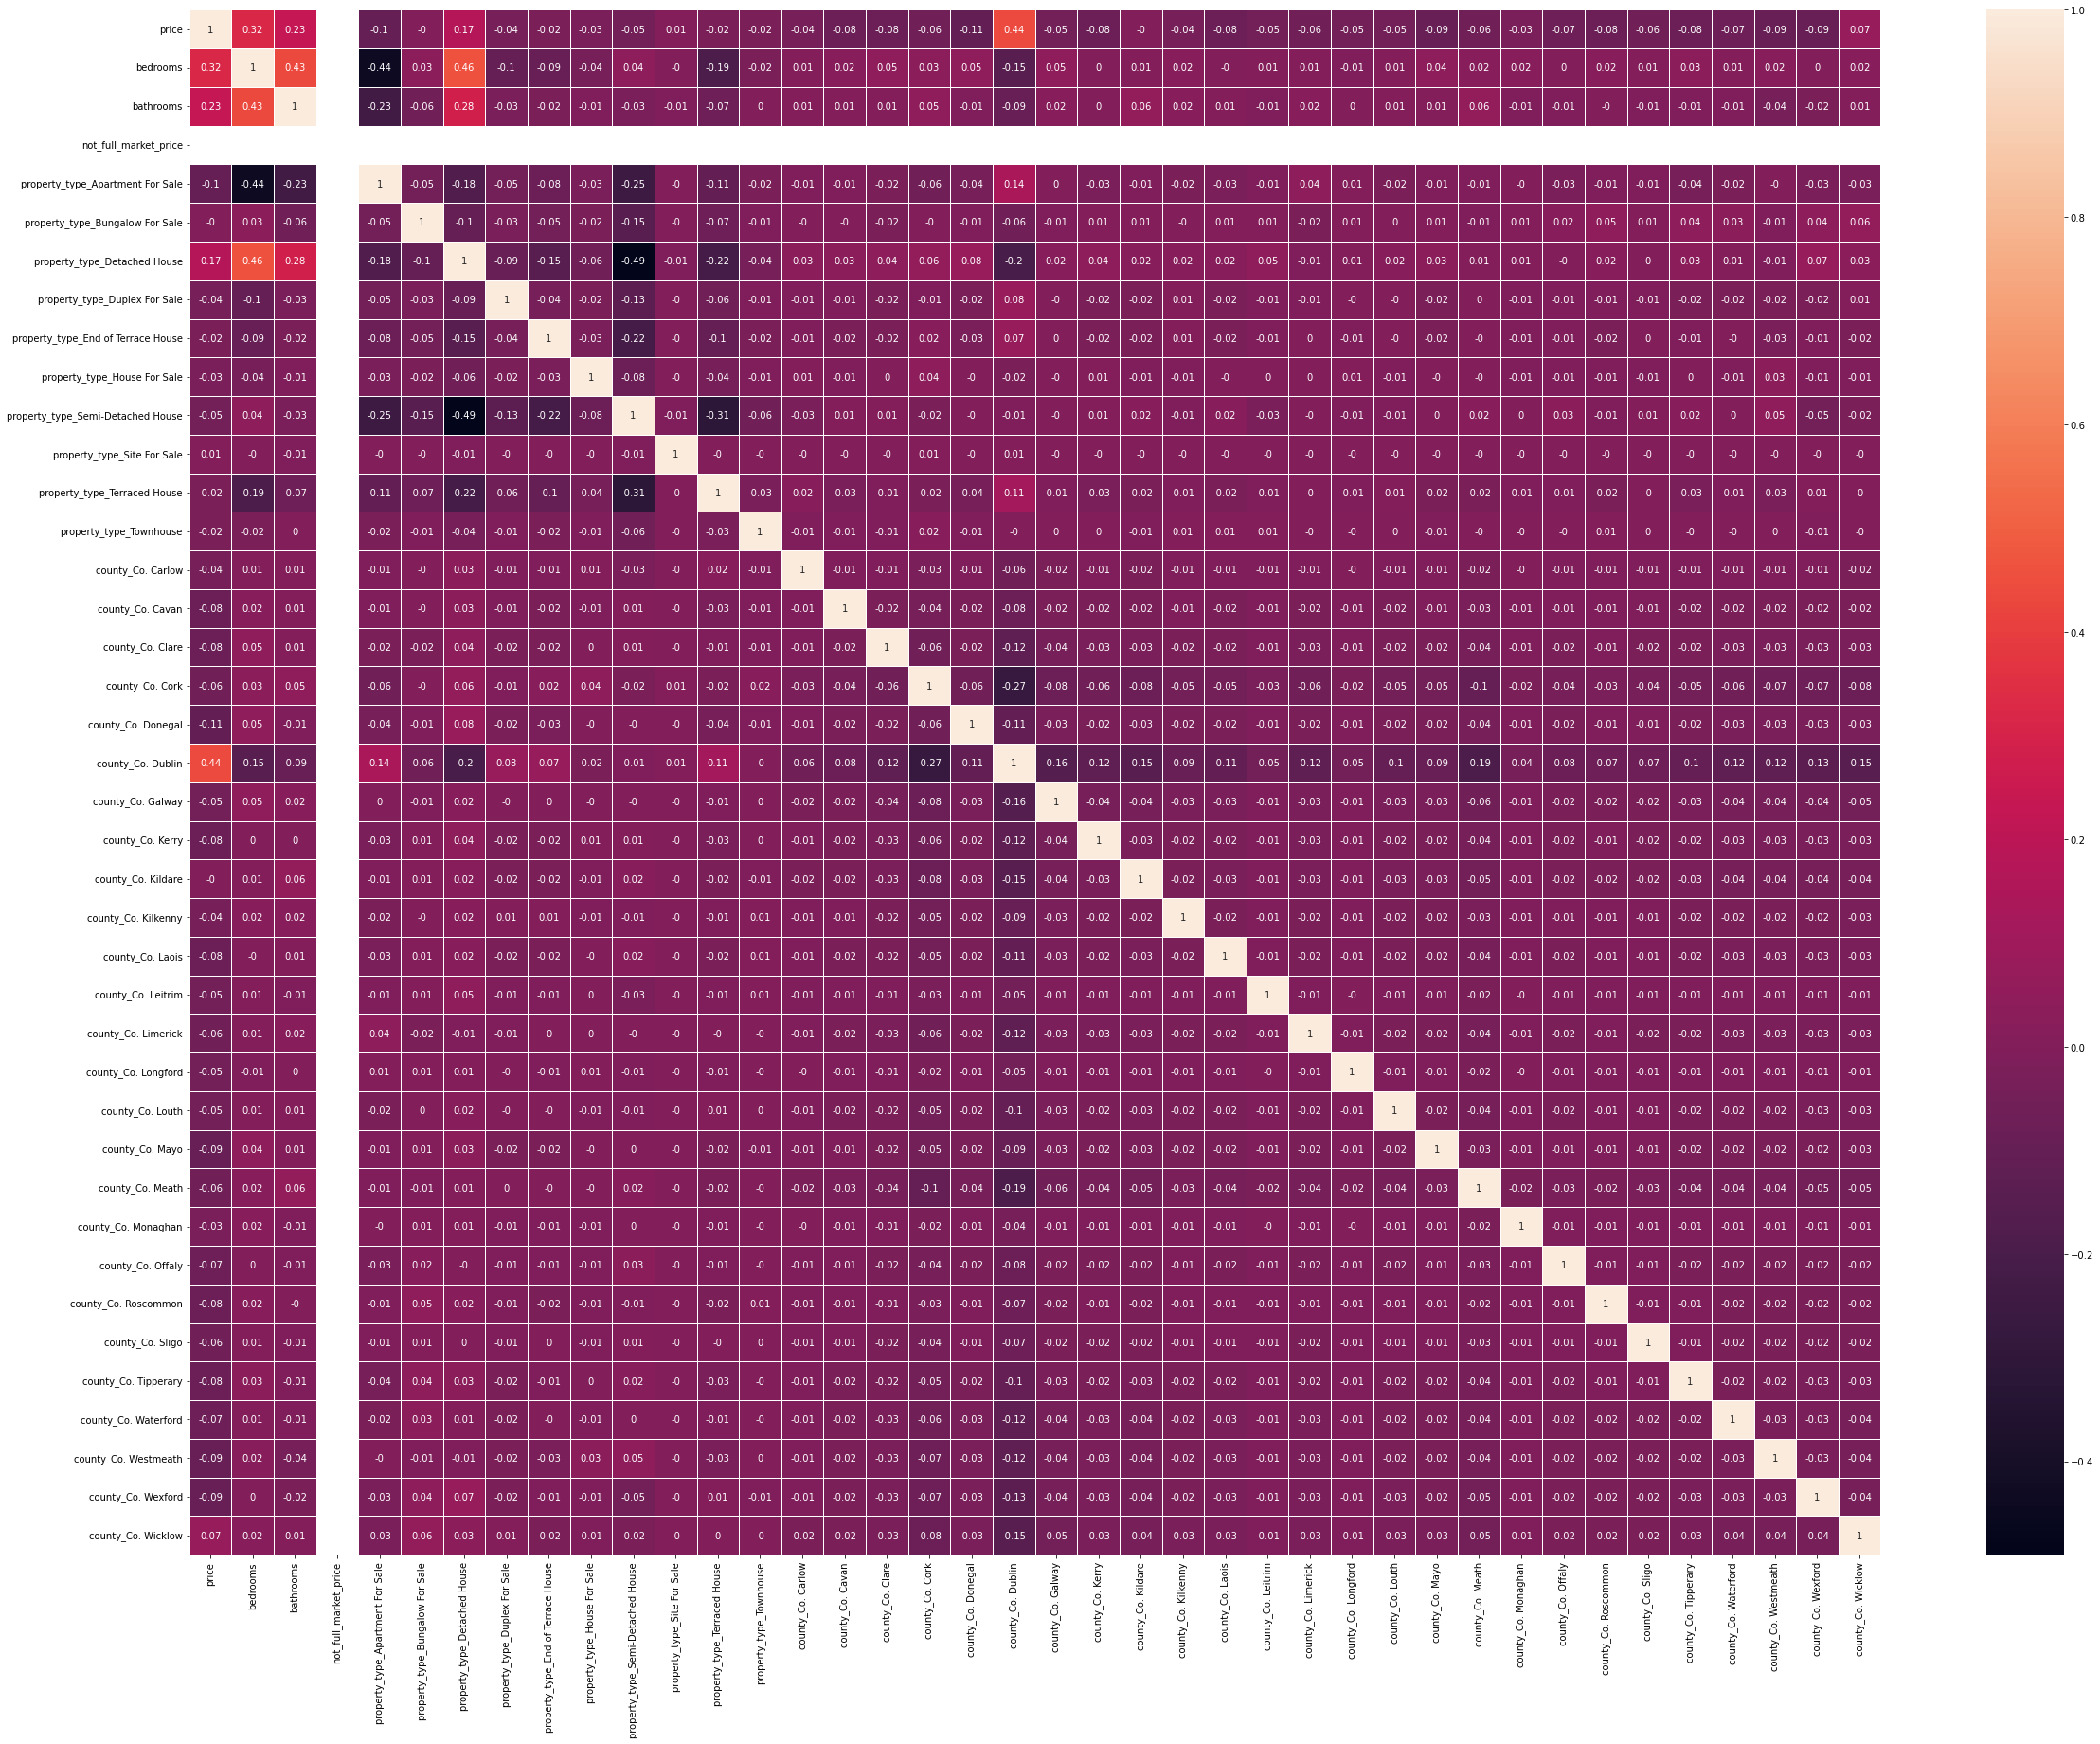

In [543]:
# want to make correlation matrix to see what data points have the most relationship.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 30))
cor_matrix = ps_df_dv.corr().round(2)
sns.heatmap(data = cor_matrix, annot=True,linewidths=.5)
plt.savefig("heatmap_all_vars.png", dpi=300)
# from the heat map I can see the biggest corelation is the number of bedrooms and whether the property in in dublin or not.
# the corelation coefficient shows there is little corelation between the regions and price.
# for this reason I will drop region outside Dublin from the regrerssion

In [544]:
# function to strip out regions that dont have a significent correlation

to_drop = ['Carlow','Cavan','Clare','Cork','Donegal','Galway','Kerry','Kildare','Kilkenny','Laois',
           'Leitrim','Limerick','Longford','Louth','Mayo','Meath','Monaghan','Offaly','Roscommon','Sligo','Tipperary',
           'Waterford','Wexford','Wicklow','Westmeath']


def strip_cols(col_name):
    for county in to_drop:
        county_string = 'county_Co. ' + county
        ps_df_dv.drop(county_string,axis=1,inplace = True)

strip_cols(to_drop)

 
    

In [545]:
ps_df_dv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17739 entries, 0 to 116758
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   price                               17739 non-null  int64  
 1   bedrooms                            17739 non-null  float64
 2   bathrooms                           17739 non-null  float64
 3   not_full_market_price               17739 non-null  bool   
 4   property_type_Apartment For Sale    17739 non-null  uint8  
 5   property_type_Bungalow For Sale     17739 non-null  uint8  
 6   property_type_Detached House        17739 non-null  uint8  
 7   property_type_Duplex For Sale       17739 non-null  uint8  
 8   property_type_End of Terrace House  17739 non-null  uint8  
 9   property_type_House For Sale        17739 non-null  uint8  
 10  property_type_Semi-Detached House   17739 non-null  uint8  
 11  property_type_Site For Sale         1773

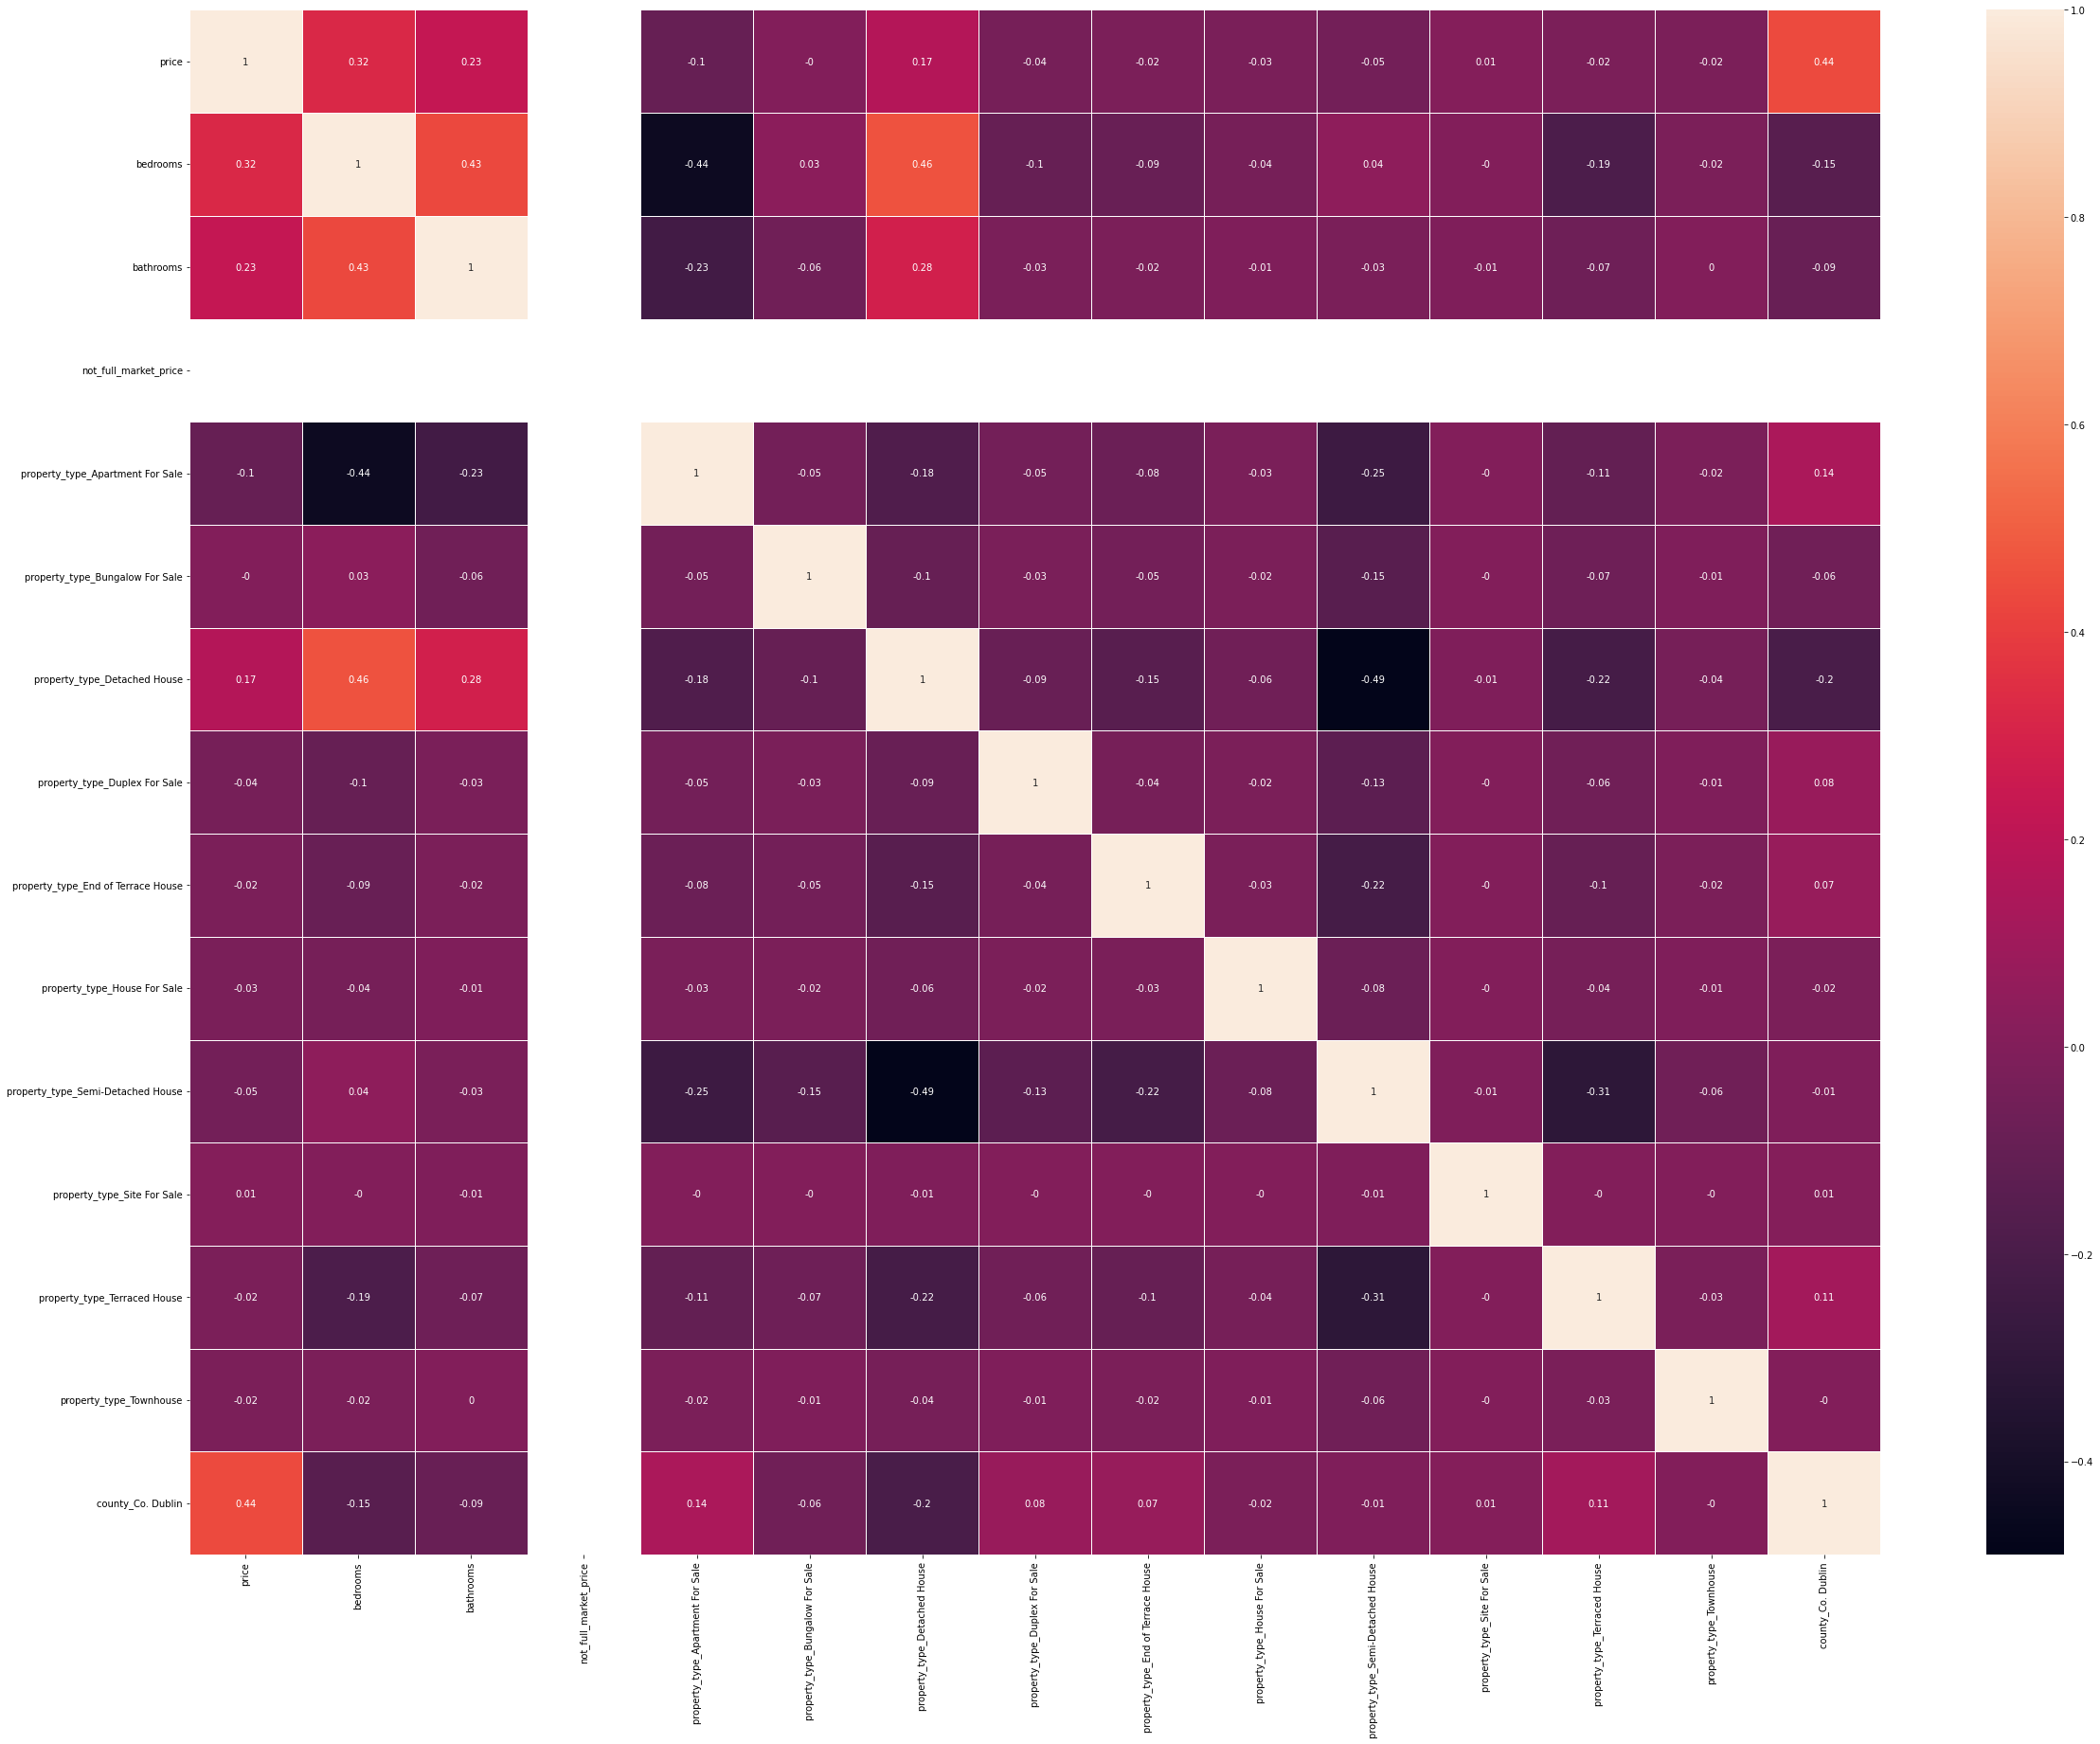

In [546]:
# re do heat map
plt.figure(figsize=(40, 30))
cor_matrix = ps_df_dv.corr().round(2)
sns.heatmap(data = cor_matrix, annot=True,linewidths=.5)
plt.savefig("heatmap_select_vars.png", dpi=300)

In [547]:
# Going through this process has made me realize there are not enough data colums to give a good result  from decision tree
# I had to abandon this line of investigation on the dataset I chose. I have incluses it because it shows a lot of the 

In [548]:
ps_df_dv.to_csv('ps_df_dv.csv', index=False)

In [549]:
# set up the array for supervised learning
X = ps_df_dv.drop('price', axis=1).values
y = ps_df_dv['price'].values


In [551]:
# Check the type to verify they ar numpy arrays.
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [552]:
# Build Logisttic regression model
#Import modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

# Create train , test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=21)

In [553]:
# instantiate the regressor
logreg = LogisticRegression(n_jobs=1,max_iter=4000)
# fit the classifier to the training data
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=4000, n_jobs=1)

In [554]:
#predict the labels of the test set
y_pred = logreg.predict(X_test)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [491]:
# Decision Tree regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split,
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score , make_scorer
from sklearn.ensemble import RandomForestRegressor


In [492]:
def fit_model(X,y):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    regressor = DecisionTreeRegressor(random_state = 0)
    dt_range = range(1,11)
    params = dict(max_depth=dt_range)
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor,params,cv=cv,scoring=scoring_fnc)
    grid = grid.fit(X,y)
    return grid.best_estimator_
fit_model(X,y)

NameError: name 'ShuffleSplit' is not defined

In [411]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=21)
dt = DecisionTreeRegressor(max_depth = 4,min_samples_leaf = 0.1,random_state=21)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
np.ceil(y_pred)
print(y_pred)
print(y_test)

[223075.12142403 326419.43415397 326419.43415397 ... 259592.68996618
 326419.43415397 380271.29751172]
[285000 200000 338000 ... 235000 270000 600000]


In [416]:
rf  = RandomForestRegressor(n_estimators=400,min_samples_leaf=.12,random_state=123)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
rmse_test = MSE(y_test,y_pred_rf)**(1/2)

In [418]:
print(rmse_test)
print(y_pred_rf)

243749.09349183374
[233490.52884112 321181.25425022 321181.25425022 ... 258895.2209986
 295776.56209273 495924.4289168 ]


In [412]:
mse_dt = MSE(y_test,y_pred)
# print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred.round(), normalize=False))
print(mse_dt)

0
50702592448.291405


In [420]:
# measure feature importance.
import_rf = pd.Series(rf.feature_importances_, index = X.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'